# Spikes

In [2]:
import numpy as np
import os
from pathlib import Path
import pandas as pd
import json
import pickle
from scipy import signal
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences, hilbert
import ephyviewer
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import matplotlib.pyplot as plt
import colorsys

In [ ]:
#Get mouse folder based on run_key
#Import spikes, spindles_info, analysis_info (unit location, fs, lfp delay)
# Keep only RE/VB units
# Bring sample timestamps down to 1000Hz, subtract lfp delay
# Create dict: key = unit, content = spike times

#graphs

In [ ]:
# list of run_keys
run_keys = [
    'NPX3_Reuniens_2024-07-24_18-40-02',
    'NPX4_Reuniens_2024-07-19_19-41-45',
    'NPX5_Reuniens_2024-07-25_17-51-48',
    'NPX6_Reuniens_2024-07-26_17-30-22',
    'NPX4_VB_2024-07-23_11-50-09',
    'NPX5_VB_2024-07-29_18-06-21',
    'NPX6_VB_2024-07-30_15-28-16',
]

spindles_info = {}
spikes_info = {}
raw_spikes = {}
unit_locations = {}

for run_key in run_keys:
    mouse = run_key.split('_')[0]
    nucleus = run_key.split('_')[1]
    date_time = run_key.split('_')[2] + '_' + run_key.split('_')[3]

    mouse_folder = f'{mouse}/{nucleus}/Expe_{date_time}/'
    spindles_info[run_key] = pd.read_pickle(mouse_folder + 'Spindles_Info.pkl')
    spikes_info[run_key] = pd.read_pickle(mouse_folder + 'Analysis_Info.pkl')
    raw_spikes = np.load(mouse_folder + 'spikes.npy')
    raw_spikes[run_key] = np.array(raw_spikes.tolist())
    unit_locations[run_key] = np.load(mouse_folder + 'unit_locations.npy')



FileNotFoundError: [Errno 2] No such file or directory: 'NPX3/Reuniens/2024-07-24_18-40-02/Spindles_Info.pkl'

In [ ]:
nucleus_units = {}
spikes_dict = {}

for run_key in run_keys:
    #Specify delays and exact sampling freq for this recording
    lfp_delay = spikes_info[run_key][lfp_delay]
    npx_real_fs = spikes_info[run_key][npx_real_fs]

    # Keep only units that are in Re/VB (based on y coordinates in spikes_info)
    lower_bound = spikes_info[run_key][lower_bound]
    upper_bound = spikes_info[run_key][upper_bound]
    nucleus_units[run_key] = np.where((unit_locations[run_key][:, 1] < upper_bound) & (unit_locations[run_key][:, 1] > lower_bound))[0]

    #Keep only spikes from good units in Re/VB
    spikes = raw_spikes[run_key][np.isin(raw_spikes[run_key][:, 1], nucleus_units[run_key])]

    #Align timestamps of spindles and spikes (account for delay between LFP and NPX)
    spikes[:, 0] -= int(round(lfp_delay*npx_real_fs))
    #Divide timestamps by ~30 (adjust for exact sampling freq) so that they fit with spindle timestamps
    spikes[:, 0] = spikes[:, 0] / (npx_real_fs/1000)



    #Classify as tonic or burst
    # assume spikes is your (N,3) array, timestamps in ms in col0, unit IDs in col1
    N = spikes.shape[0]

    # Prepare an output array of zeros
    burst_labels = np.zeros(N, dtype=np.int32)

    # Process each unit separately, in original order
    for uid in nucleus_units[run_key]:
        # get the row-indices for this unit (in the original order)
        idxs = np.where(spikes[:,1] == uid)[0]
        if idxs.size == 0:
            continue

        # extract the timestamps for those rows
        times = spikes[idxs, 0]
        # compute inter-spike intervals
        isi = np.diff(times)

        # temporary array for this unit’s burst positions
        burst_pos = np.zeros(idxs.size, dtype=np.int32)

        i = 0
        while i < isi.size:
            if isi[i] <= 8:
                # We’ve found the *start* of a burst: 
                # the interval between spike i and spike i+1 is ≤ 8 ms.
                
                length = 2
                # “length” counts how many spikes are in this burst so far.
                # We already know spikes at positions i and i+1 are in a burst,
                # so length=2 to start.

                # Now extend the burst as long as the next intervals are ≤ 8 ms.
                # isi[i + length - 1] is the next interval to check.
                # We stop if we run out of intervals or hit one > 8 ms.
                while (i + length - 1 < isi.size) and (isi[i + length - 1] <= 8):
                    length += 1

                # At this point “length” = total spikes in the burst.
                # We label burst_pos[i : i+length] = [1,2,...,length].
                # These indices correspond to the spikes from the start of this burst
                # through the last one that satisfied the ≤8 ms rule.
                burst_pos[i : i + length] = np.arange(1, length + 1)

                # Skip over this entire burst so we don’t relabel it.
                i += length
            else:
                # Not a burst-start interval, move to the next interval.
                i += 1

        # write back into the global array
        burst_labels[idxs] = burst_pos

    # Stuff labels into column 2 of spikes
    spikes[:, 2] = burst_labels

    #Add final spikes array to spikes_dict
    spikes_dict[run_key] = spikes

In [ ]:
# assume spikes is your (N,3) array, timestamps in ms in col0, unit IDs in col1
N = spikes.shape[0]

# Prepare an output array of zeros
burst_labels = np.zeros(N, dtype=np.int32)

# Process each unit separately, in original order
for uid in re_units:
    # get the row-indices for this unit (in the original order)
    idxs = np.where(spikes[:,1] == uid)[0]
    if idxs.size == 0:
        continue

    # extract the timestamps for those rows
    times = spikes[idxs, 0]
    # compute inter-spike intervals
    isi = np.diff(times)

    # temporary array for this unit’s burst positions
    burst_pos = np.zeros(idxs.size, dtype=np.int32)

    i = 0
    while i < isi.size:
        if isi[i] <= 8:
            # We’ve found the *start* of a burst: 
            # the interval between spike i and spike i+1 is ≤ 8 ms.
            
            length = 2
            # “length” counts how many spikes are in this burst so far.
            # We already know spikes at positions i and i+1 are in a burst,
            # so length=2 to start.

            # Now extend the burst as long as the next intervals are ≤ 8 ms.
            # isi[i + length - 1] is the next interval to check.
            # We stop if we run out of intervals or hit one > 8 ms.
            while (i + length - 1 < isi.size) and (isi[i + length - 1] <= 8):
                length += 1

            # At this point “length” = total spikes in the burst.
            # We label burst_pos[i : i+length] = [1,2,...,length].
            # These indices correspond to the spikes from the start of this burst
            # through the last one that satisfied the ≤8 ms rule.
            burst_pos[i : i + length] = np.arange(1, length + 1)

            # Skip over this entire burst so we don’t relabel it.
            i += length
        else:
            # Not a burst-start interval, move to the next interval.
            i += 1

    # write back into the global array
    burst_labels[idxs] = burst_pos

# Stuff labels into column 2 of spikes
spikes[:, 2] = burst_labels

In [ ]:
#Create array with info for peri-spindle histogram
psh_spindle = {}
for run_key in run_keys:
    col = np.linspace(-1950,2000,80)
    psh_spindle[run_key] = {}

    for key in sorted(spindles_info[run_key]):
        psh_spindle[run_key][key] = pd.DataFrame(0, index=nucleus_units[run_key], columns=col)

        for _, spindle in spindles_info[run_key][key].iterrows():
            start = int(spindle['spindle_start'])
            end = int(spindle['spindle_end'])
            width = int(spindle['spindle_duration'])

            spikes_around_spindle = spikes[(spikes[:, 0] >= start-2000) & (spikes[:, 0] <= start+2000)]
            for ap in spikes_around_spindle:
                if ap[2] ==1:  # ==0 tonic, ==1 first of burst
                    unit    = int(ap[1])
                    rel_t   = ap[0] - start            # relative time in ms
                    idx = np.digitize(rel_t, col, right=True)
                    bin_edge = col[idx]
                    # increment that cell
                    psh_spindle[run_key][key].at[unit, bin_edge] += 1
        #Divide counts by nb of spindles and bin size (0.05 sec) to get averaged instantaneous firing rate
        psh_spindle[run_key][key] /= (len(spindles_info[run_key][key])*0.05)

In [ ]:
#or for overlapping spindles
psh_overlap = pd.DataFrame(0, index=re_units, columns=col)

for _, spindle in common.iterrows():
    start = int(spindle['spindle_start'])
    end = int(spindle['spindle_end'])
    width = end-start

    spikes_around_spindle = spikes[(spikes[:, 0] >= start-2000) & (spikes[:, 0] <= start+2000)]
    for ap in spikes_around_spindle:
        if ap[2] ==0:  # ==0 tonic, ==1 first of burst
            unit    = int(ap[1])
            rel_t   = ap[0] - start            # relative time in ms
            idx = np.digitize(rel_t, col, right=True)
            bin_edge = col[idx]
            # increment that cell
            psh_overlap.at[unit, bin_edge] += 1
#Divide counts by nb of spindles and bin size (0.05 sec) to get averaged instantaneous firing rate
psh_overlap /= (len(common)*0.05)

# Plots

In [ ]:
import numpy as np
import os
import pandas as pd
import json
import pickle
from scipy import signal
from scipy.signal import chirp, find_peaks, peak_widths, peak_prominences, hilbert
import ephyviewer
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import matplotlib.pyplot as plt
import colorsys

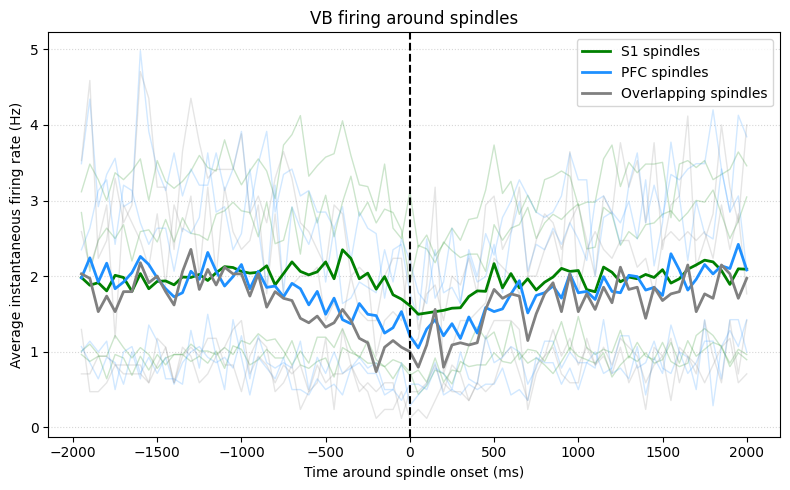

In [ ]:
# Extract time‐bin centers from the column labels
times = psh_spindle[3].columns.astype(float)

plt.figure(figsize=(8, 5))

# 1) Plot each unit in light/translucent blue
for unit in psh_spindle[3].index:
    plt.plot(times,
             psh_spindle[3].loc[unit].values,
             color='green',
             alpha=0.2,
             linewidth=1)
for unit in psh_spindle[8].index:
    plt.plot(times,
             psh_spindle[8].loc[unit].values,
             color='dodgerblue',
             alpha=0.2,
             linewidth=1)
for unit in psh_overlap.index:
    plt.plot(times,
             psh_overlap.loc[unit].values,
             color='gray',
             alpha=0.2,
             linewidth=1)

# 2) Compute & plot the mean across all units in solid blue
mean_spikes_3 = psh_spindle[3].mean(axis=0)
mean_spikes_8 = psh_spindle[8].mean(axis=0)
mean_spikes_overlap = psh_overlap.mean(axis=0)
plt.plot(times,
         mean_spikes_3.values,
         color='green',
         linewidth=2,
         label='S1 spindles')
plt.plot(times,
         mean_spikes_8.values,
         color='dodgerblue',
         linewidth=2,
         label='PFC spindles')
plt.plot(times,
         mean_spikes_overlap.values,
         color='gray',
         linewidth=2,
         label='Overlapping spindles')

# 3) Dashed vertical at 0 (spindle onset)
plt.axvline(0, color='black', linestyle='--')

# 4) Labels, title, legend
plt.xlabel('Time around spindle onset (ms)')
plt.ylabel('Average instantaneous firing rate (Hz)')
plt.title('VB firing around spindles')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


In [43]:
barplot_S1 = np.array([[psh_spindle[3].loc[:, -600:-350].mean(axis=1)], [psh_spindle[3].loc[:, -300:-50].mean(axis=1)], [psh_spindle[3].loc[:, 0:250].mean(axis=1)]])
barplot_PFC = np.array([[psh_spindle[8].loc[:, -600:-350].mean(axis=1)], [psh_spindle[8].loc[:, -300:-50].mean(axis=1)], [psh_spindle[8].loc[:, 0:250].mean(axis=1)]])
barplot_overlap = np.array([[psh_overlap.loc[:, -600:-350].mean(axis=1)], [psh_overlap.loc[:, -300:-50].mean(axis=1)], [psh_overlap.loc[:, 0:250].mean(axis=1)]])


In [ ]:
unit_phaselock_S1 = {unit: [] for unit in re_units}

for i, spindle in spindles_info[3].iterrows():
    start = spindle["spindle_start"]
    end = spindle["spindle_end"]
    inst_phase = spindle["inst_phase"]

    mask = (spikes[:,0] >= start) & (spikes[:,0] < end)
    spindle_spikes = spikes[mask]
    # Keep only tonic spikes (column 2 is 0) or first spike of burst (col 2 is 1)
    spindle_spikes = spindle_spikes[spindle_spikes[:, 2] == 1]

    for unit in re_units:
        unit_timestamps = spindle_spikes[spindle_spikes[:, 1] == unit][:, 0].tolist()
        #print(start, end, unit_timestamps, end-start, len(inst_phase))

        if len(unit_timestamps)>=3:  #only calculate phase if at least 5 firings during spindle
            phase_values = []
            for spike_time in unit_timestamps:
                idx = int(round(spike_time - start))  # offset = index
                if 0 <= idx < len(inst_phase):  # avoid out-of-bounds
                    phase_values.append(inst_phase[idx])
            #print(phase_values)

            phase_diff = np.array(phase_values)
            #Calculate circular mean of phase lag
            unit_vectors = np.exp(1j * phase_diff)   # 1: Project onto unit circle using Euler's formula
            mean_vector = np.mean(unit_vectors) # 2: Compute mean vector
            mean_phase_diff = np.angle(mean_vector)  # 3: Get mean phase (angle)
            vector_strength = np.abs(mean_vector)   # 4: Get magnitude (locking strength)

            unit_phaselock_S1[unit].append([i, mean_phase_diff, vector_strength])
            #print(i, mean_phase_diff, vector_strength)
        #else:
            #print("noop")

In [ ]:
unit_phaselock_PFC = {unit: [] for unit in re_units}

for i, spindle in spindles_info[8].iterrows():
    start = spindle["spindle_start"]
    end = spindle["spindle_end"]
    inst_phase = spindle["inst_phase"]

    mask = (spikes[:,0] >= start) & (spikes[:,0] <= end)
    spindle_spikes = spikes[mask]

    for unit in re_units:
        unit_timestamps = spindle_spikes[spindle_spikes[:, 1] == unit][:, 0].tolist()
        print(start, end, unit_timestamps, end-start, len(inst_phase))

        if len(unit_timestamps)>4:  #only calculate phase if at least 5 firings during spindle
            phase_values = []
            for spike_time in unit_timestamps:
                idx = int(round(spike_time - start))  # offset = index
                if 0 <= idx < len(inst_phase):  # avoid out-of-bounds
                    phase_values.append(inst_phase[idx])
            print(phase_values)

            phase_diff = np.array(phase_values)
            #Calculate circular mean of phase lag
            unit_vectors = np.exp(1j * phase_diff)   # 1: Project onto unit circle using Euler's formula
            mean_vector = np.mean(unit_vectors) # 2: Compute mean vector
            mean_phase_diff = np.angle(mean_vector)  # 3: Get mean phase (angle)
            vector_strength = np.abs(mean_vector)   # 4: Get magnitude (locking strength)

            unit_phaselock_PFC[unit].append([i, mean_phase_diff, vector_strength])
            print(i, mean_phase_diff, vector_strength)
        else:
            print("noop")

In [ ]:
unit_phaselock_RSP = {unit: [] for unit in re_units}

for i, spindle in spindles_info[8].iterrows():
    start = spindle["spindle_start"]
    end = spindle["spindle_end"]
    inst_phase = spindle["inst_phase"]

    mask = (spikes[:,0] >= start) & (spikes[:,0] <= end)
    spindle_spikes = spikes[mask]

    for unit in re_units:
        unit_timestamps = spindle_spikes[spindle_spikes[:, 1] == unit][:, 0].tolist()
        print(start, end, unit_timestamps, end-start, len(inst_phase))

        if len(unit_timestamps)>4:  #only calculate phase if at least 5 firings during spindle
            phase_values = []
            for spike_time in unit_timestamps:
                idx = int(round(spike_time - start))  # offset = index
                if 0 <= idx < len(inst_phase):  # avoid out-of-bounds
                    phase_values.append(inst_phase[idx])
            print(phase_values)

            phase_diff = np.array(phase_values)
            #Calculate circular mean of phase lag
            unit_vectors = np.exp(1j * phase_diff)   # 1: Project onto unit circle using Euler's formula
            mean_vector = np.mean(unit_vectors) # 2: Compute mean vector
            mean_phase_diff = np.angle(mean_vector)  # 3: Get mean phase (angle)
            vector_strength = np.abs(mean_vector)   # 4: Get magnitude (locking strength)

            unit_phaselock_RSP[unit].append([i, mean_phase_diff, vector_strength])
            print(i, mean_phase_diff, vector_strength)
        else:
            print("noop")

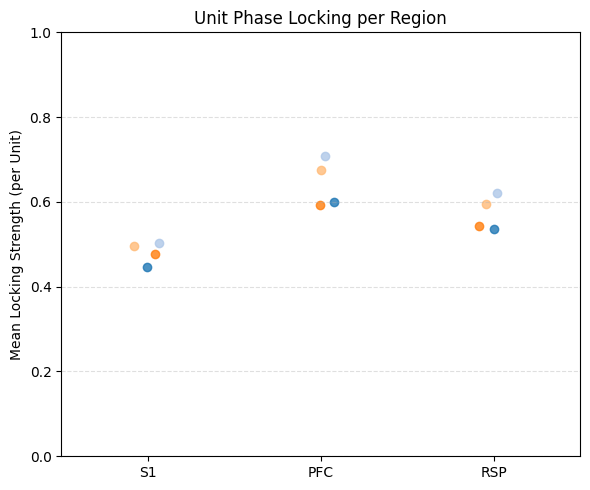

In [263]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def get_mean_strengths_per_unit(phaselock_dict):
    means = []
    unit_ids = []
    for unit_id, events in phaselock_dict.items():
        if events:
            strengths = [entry[2] for entry in events]
            means.append(np.mean(strengths))
            unit_ids.append(unit_id)
    return means, unit_ids

# Get per-unit mean locking strength
means_S1, units_S1 = get_mean_strengths_per_unit(unit_phaselock_S1)
means_PFC, units_PFC = get_mean_strengths_per_unit(unit_phaselock_PFC)
means_RSP, units_RSP = get_mean_strengths_per_unit(unit_phaselock_RSP)

# Combine all unit IDs and assign consistent colors
all_unit_ids = sorted(set(units_S1 + units_PFC + units_RSP))
color_map = {uid: cm.tab20(i % 20) for i, uid in enumerate(all_unit_ids)}

# X values with jitter
x_S1 = np.random.normal(0, 0.05, size=len(means_S1))
x_PFC = np.random.normal(1, 0.05, size=len(means_PFC))
x_RSP = np.random.normal(2, 0.05, size=len(means_RSP))

# Plot
plt.figure(figsize=(6, 5))
for i in range(len(means_S1)):
    plt.scatter(x_S1[i], means_S1[i], color=color_map[units_S1[i]], label=f'Unit {units_S1[i]}' if i == 0 else "", alpha=0.8)
for i in range(len(means_PFC)):
    plt.scatter(x_PFC[i], means_PFC[i], color=color_map[units_PFC[i]], label=f'Unit {units_PFC[i]}' if i == 0 else "", alpha=0.8)
for i in range(len(means_RSP)):
    plt.scatter(x_RSP[i], means_RSP[i], color=color_map[units_RSP[i]], label=f'Unit {units_RSP[i]}' if i == 0 else "", alpha=0.8)

plt.xticks([0, 1, 2], ['S1', 'PFC', 'RSP'])
plt.ylabel('Mean Locking Strength (per Unit)')
plt.title('Unit Phase Locking per Region')
plt.xlim(-0.5, 2.5)
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

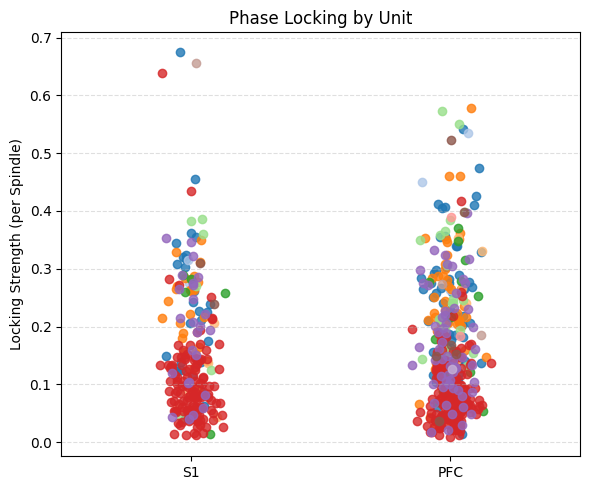

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

def get_strengths_and_unit_ids(phaselock_dict):
    strengths = []
    unit_ids = []
    for unit_id, events in phaselock_dict.items():
        for entry in events:
            strengths.append(entry[2])
            unit_ids.append(unit_id)
    return strengths, unit_ids

# Get data
strengths_S1, units_S1 = get_strengths_and_unit_ids(unit_phaselock_S1)
strengths_PFC, units_PFC = get_strengths_and_unit_ids(unit_phaselock_PFC)

# Map unit IDs to colors
all_unit_ids = sorted(set(units_S1 + units_PFC))
color_map = {uid: cm.tab20(i % 20) for i, uid in enumerate(all_unit_ids)}

# Jittered x positions
x_S1 = np.random.normal(0, 0.05, size=len(strengths_S1))
x_PFC = np.random.normal(1, 0.05, size=len(strengths_PFC))

# Plot
plt.figure(figsize=(6, 5))
for i in range(len(strengths_S1)):
    plt.scatter(x_S1[i], strengths_S1[i], color=color_map[units_S1[i]], alpha=0.8)
for i in range(len(strengths_PFC)):
    plt.scatter(x_PFC[i], strengths_PFC[i], color=color_map[units_PFC[i]], alpha=0.8)

plt.xticks([0, 1], ['S1', 'PFC'])
plt.ylabel('Locking Strength (per Spindle)')
plt.title('Phase Locking by Unit')
plt.xlim(-0.5, 1.5)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
polar_plot = {}

for key in sorted(spindles_info):
    polar_plot[key] = {unit: [] for unit in re_units}

    for i, spindle in spindles_info[key].iterrows():
        start = spindle["spindle_start"]
        end = spindle["spindle_end"]
        inst_phase = spindle["inst_phase"]

        mask = (spikes[:,0] >= start) & (spikes[:,0] < end)
        spindle_spikes = spikes[mask]
        # Keep only tonic spikes (column 2 is 0) or first spike of burst (col 2 is 1)
        spindle_spikes = spindle_spikes[spindle_spikes[:, 2] == 1]

        for unit in re_units:
            unit_timestamps = spindle_spikes[spindle_spikes[:, 1] == unit][:, 0].tolist()

            for spike_time in unit_timestamps:
                idx = int(round(spike_time - start))  # offset = index
                polar_plot[key][unit].append(inst_phase[idx])

    for unit in re_units:
        phase_diff = np.array(polar_plot[key][unit])
        #Calculate circular mean of phase lag
        unit_vectors = np.exp(1j * phase_diff)   # 1: Project onto unit circle using Euler's formula
        mean_vector = np.mean(unit_vectors) # 2: Compute mean vector
        mean_phase_diff = np.angle(mean_vector)  # 3: Get mean phase (angle)
        vector_strength = np.abs(mean_vector)   # 4: Get magnitude (locking strength)

        polar_plot[key][unit] = pd.DataFrame(data=[[mean_phase_diff, vector_strength, polar_plot[key][unit]]], columns=["mean_phase_diff", "vector_strength", "phase_datapoints"])
        print(polar_plot[key][unit])

   mean_phase_diff  vector_strength  \
0         0.470314         0.034829   

                                    phase_datapoints  
0  [-0.699, 1.9375, 0.5425, -2.838, -2.416, 2.004...  
   mean_phase_diff  vector_strength  \
0         0.927012         0.035881   

                                    phase_datapoints  
0  [1.312, 0.4214, 2.484, -1.516, -3.1, 1.042, 1....  
   mean_phase_diff  vector_strength  \
0         1.073314         0.072206   

                                    phase_datapoints  
0  [-2.922, -1.499, 1.908, 1.349, 0.787, -2.934, ...  
   mean_phase_diff  vector_strength  \
0        -2.912941         0.062055   

                                    phase_datapoints  
0  [-2.639, -0.2673, -0.2117, 0.1412, -1.92, -2.5...  
   mean_phase_diff  vector_strength  \
0         3.022416         0.030718   

                                    phase_datapoints  
0  [-1.173, 2.254, 2.32, -1.471, 0.775, 0.3684, 0...  
   mean_phase_diff  vector_strength  \
0         1.8688

In [158]:
key = 8

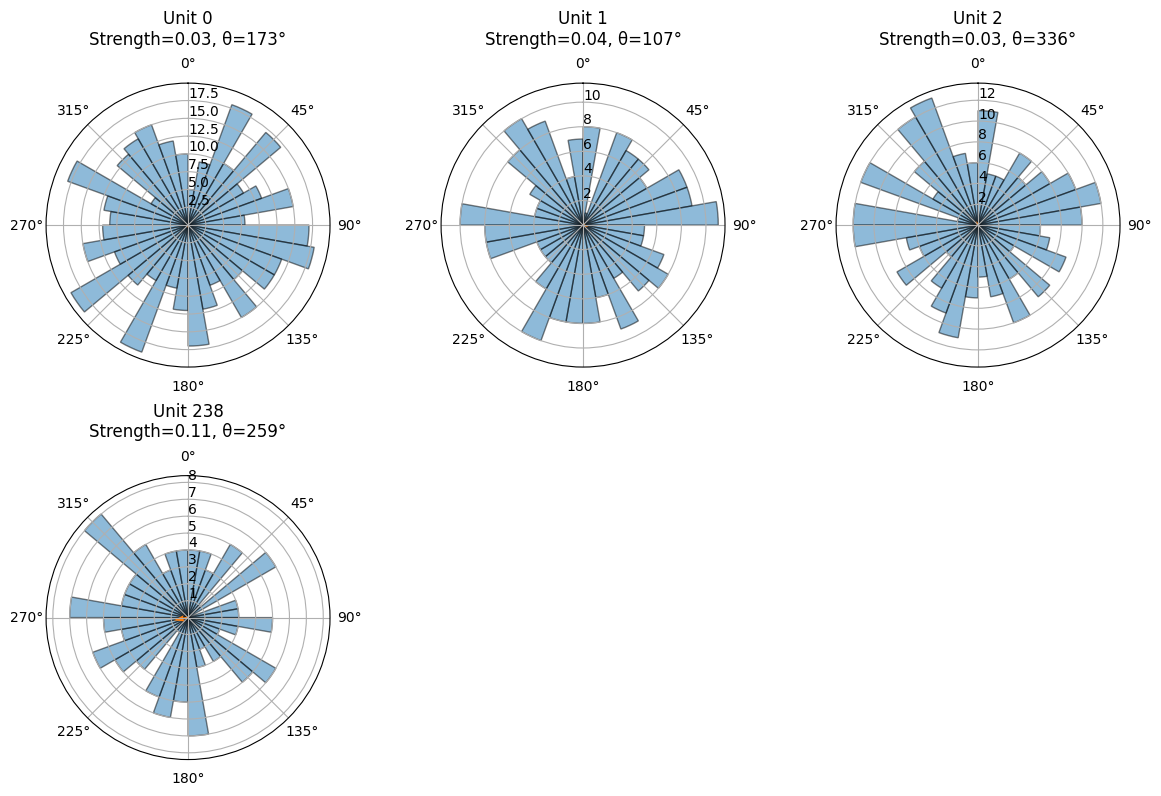

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Configuration
units = sorted(polar_plot[key].keys())
n_units = len(units)
n_cols  = 3
n_rows  = math.ceil(n_units / n_cols)
n_bins  = 36

# Prepare figure with polar subplots
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 4 * n_rows),
    subplot_kw=dict(polar=True)
)
axes = axes.flatten()

for ax, unit in zip(axes, units):
    # 1) Extract data
    df = polar_plot[key][unit]
    phases          = np.array(df.loc[0, "phase_datapoints"])
    mean_phase      = df.loc[0, "mean_phase_diff"]
    vector_strength = df.loc[0, "vector_strength"]

    # 2) Build histogram
    bins = np.linspace(-np.pi, np.pi, n_bins + 1)
    counts, _ = np.histogram(phases, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # 3a) Rose bars
    ax.bar(
        bin_centers,
        counts,
        width=(2 * np.pi / n_bins),
        bottom=0.0,
        color="C0",
        alpha=0.5,
        edgecolor="k"
    )

    # 3b) Mean vector (wrapped, scaled)
    phase = (mean_phase + 2*np.pi) % (2*np.pi)
    arrow_r = vector_strength * counts.max()
    ax.quiver(
        phase, 0,
        0, arrow_r,
        angles='xy',
        scale_units='xy',
        scale=1.0,
        color='C1',
        linewidth=2,
        label=f"Strength: {vector_strength:.2f}, Phase: {phase*360/(2*np.pi):.0f}"
    )

    # 4) Decorations
    ax.set_ylim(0, counts.max() * 1.05)
    ax.set_rlabel_position(0)
    ax.tick_params(axis='y', pad=10)
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_title(
    f"Unit {unit}\n"
    f"Strength={vector_strength:.2f}, θ={phase*360/(2*np.pi):.0f}°",
    va='bottom'
    )

# Turn off any unused subplots
for ax in axes[n_units:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
